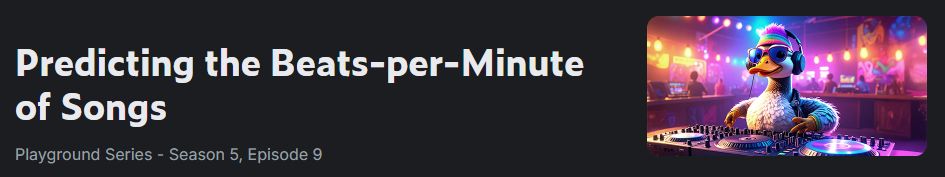
* https://www.kaggle.com/competitions/playground-series-s5e9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings(action='ignore')

# scikit-learn
import sklearn

# 수치형 변환
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# PCA (차원 축소 : 주성분분석)
from sklearn.decomposition import PCA

# 문제지, 답안지 분리
from sklearn.model_selection import train_test_split

# 회귀 모델 (+ 통계)
# from sklearn.linear_model import LogisticRegression --> 분류 모델 / 회귀 XXXXXXXX
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 외부(Google) 회귀모델 (+ 별도설치 )
# import xgboost as xgb
# import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 정규화 / 스케일러
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 교차 검증 : StratifiedKFold (y를 고르게 폴드에 분배한다는 것은 회귀에서 없다) 
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

# 회귀 평가 매트릭스
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

# 앙상블
from sklearn.ensemble import StackingRegressor

# 파이프라인
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# 피쳐 셀렉션
from sklearn.feature_selection import SelectFromModel

# 튜닝
# from pycaret.regression import *

# matplotlib 차트 스타일을 seaborn 스타일로 설정
sns.set()

# ----------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

# EDA

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdm** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

In [3]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

,rs,al,vc,aq,is,lpl,ms,tdm,e,bpm
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


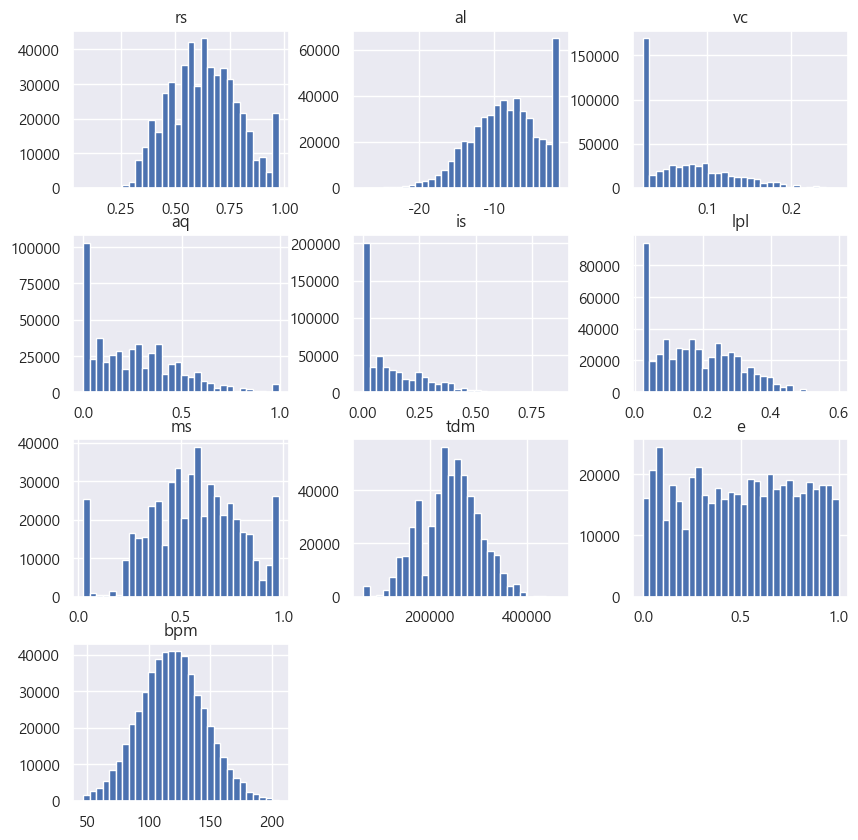

In [5]:
df.hist(figsize=(10, 10), bins=30)
plt.show()

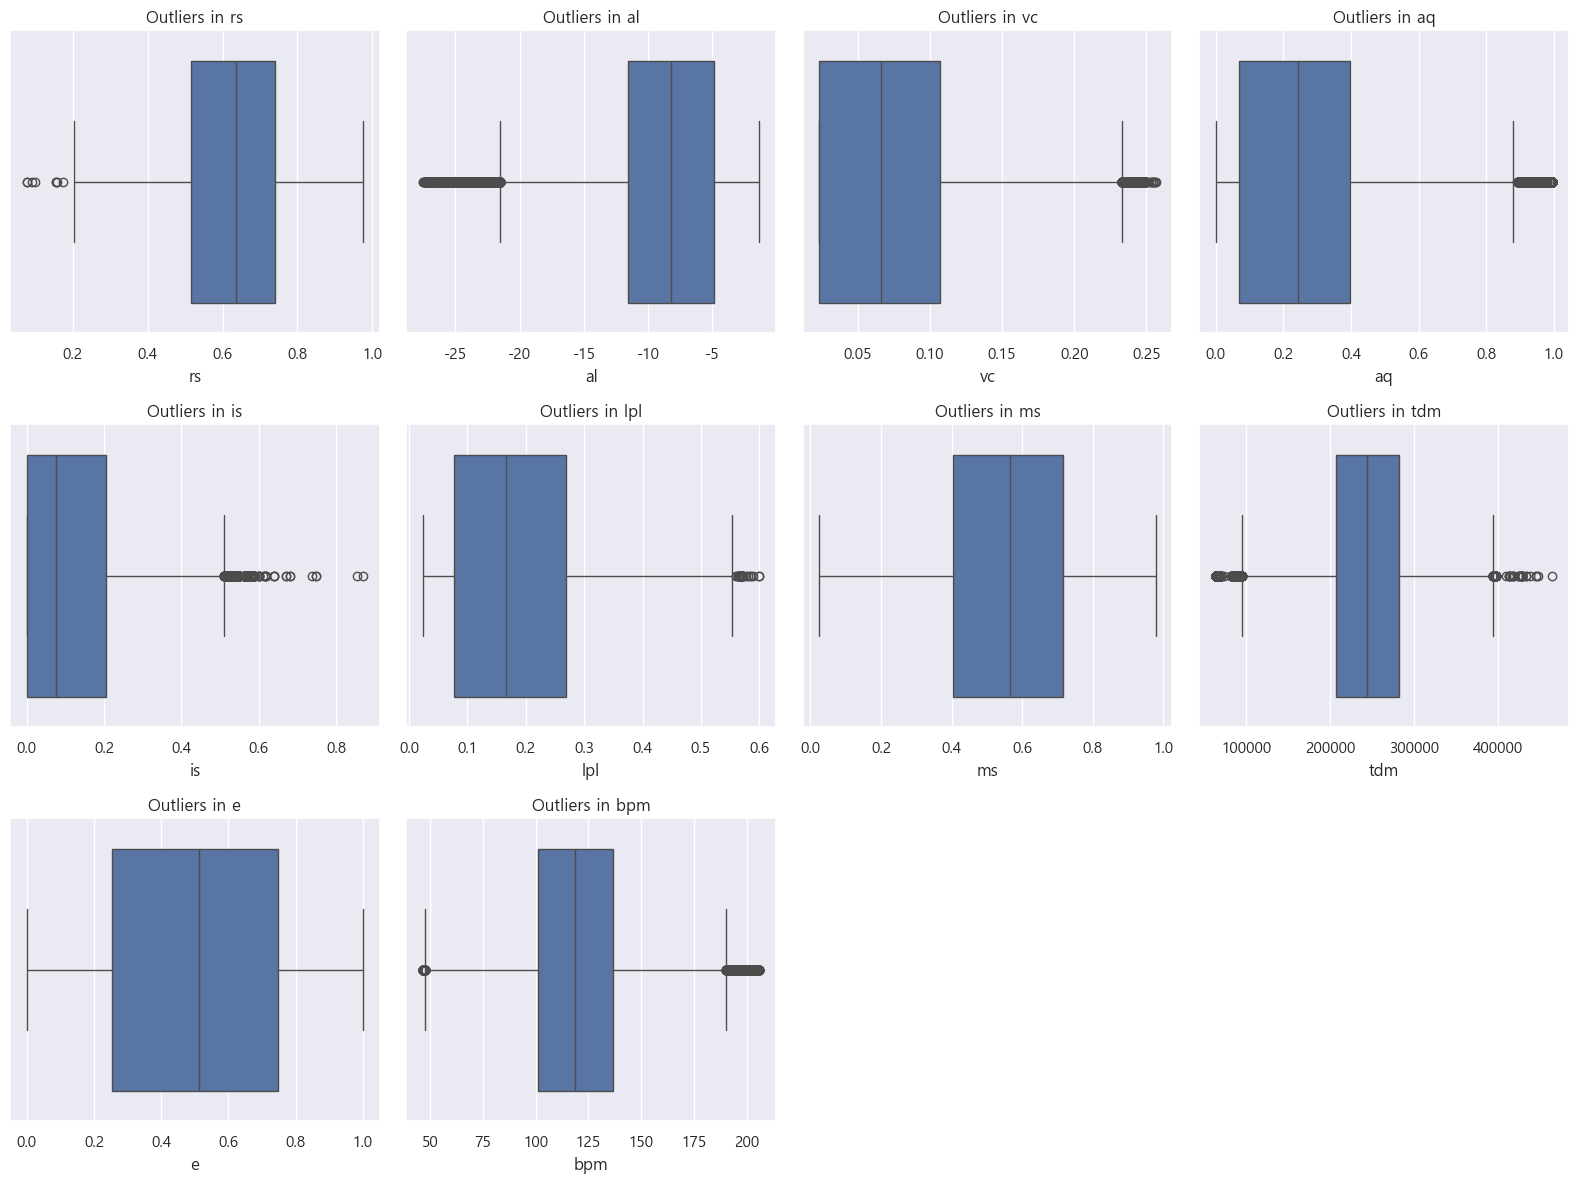

In [6]:
# 분석할 숫자형 특성들 선택
# num_features = df.columns
num_features = df.select_dtypes(include=np.number).columns.tolist()

# 1. 전체 그림의 크기와 격자(grid) 설정
n_features = len(num_features)
n_cols = 4  # 한 줄에 그릴 그래프의 개수 (원하는 대로 조절)
n_rows = math.ceil(n_features / n_cols) # 필요한 줄의 개수 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 다루기 쉽게 함

# 2. for문을 사용하여 각 subplot에 boxplot 그리기
for i, col in enumerate(num_features):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 3. 남는 빈 subplot들은 보이지 않게 처리
for j in range(n_features, len(axes)):
    axes[j].axis('off')

# 4. 전체 그림을 보기 좋게 조정하고 출력
plt.tight_layout()
plt.show()

# myscore 공통함수

In [7]:
# ----------------------------------------------------
# 이전 점수를 저장할 변수
previous_scores = None
# ----------------------------------------------------

def myscore(X80=None, y80=None, X20=None, y20=None, model=None, df=None, fi=None, top_n=None):
    """
    모델을 학습/평가하고, fi=True일 경우 피쳐 중요도를 시각화합니다.
    - fi: True로 설정하면 피쳐 중요도를 출력합니다.
    - top_n: None이면 모든 피쳐, 숫자를 입력하면 상위 n개의 중요도를 보여줍니다.
    """
    global previous_scores
    
    # 데이터 분할 로직 (기존과 동일)
    if df is not None:
        y = df['bpm']
        X = df.drop('bpm', axis=1)
        X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)
    
    if model is None:
        model = XGBRegressor(random_state=8989)
    
    # 모델 학습 및 예측 (기존과 동일)
    model.fit(X80, y80)
    pred = model.predict(X20)
    
    # 점수 계산 및 비교 출력 (기존과 동일)
    mse = mean_squared_error(y20, pred)
    rmse = root_mean_squared_error(y20, pred)
    r2 = r2_score(y20, pred)
    current_scores = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
    
    print(f'MODEL : {model.__class__.__name__}\nMSE : {mse:.4f}\nRMSE : {rmse:.4f}\nR2 : {r2:.4f}')
    print("-" * 30)

    if previous_scores:
        print("--- Score Comparison (Current vs Previous) ---")
        for key, current_val in current_scores.items():
            prev_val = previous_scores.get(key, 0)
            diff = current_val - prev_val
            if key == 'R2':
                is_good = "📈" if diff > 0 else "📉"
            else:
                is_good = "📈" if diff < 0 else "📉"
            print(f'{key:<5}: {current_val:.4f} vs {prev_val:.4f} (Change: {diff:+.4f}) {is_good}')
    else:
        print("첫 번째 실행이므로 비교할 이전 점수가 없습니다.")

    print("-" * 30 + "\n")
    previous_scores = current_scores

    # Feature Importance 시각화
    if fi:
        if isinstance(model, Pipeline):
            actual_model = model.steps[-1][1]
        else:
            actual_model = model

        if not hasattr(actual_model, 'feature_importances_'):
            print(f"\nNOTE: 이 모델({actual_model.__class__.__name__})은 feature_importances_ 속성이 없습니다.")
            return

        importances = actual_model.feature_importances_
        feature_names = X80.columns
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        fi_df = fi_df.sort_values(by='importance', ascending=False)

        title_text = f'Feature Importances ({actual_model.__class__.__name__})'
        # top_n 값이 주어지면 해당 개수만큼만 선택
        if top_n is not None:
            fi_df = fi_df.head(top_n)
            title_text = f'Top {top_n} ' + title_text

        # Seaborn으로 세로 막대 그래프 시각화
        plt.figure(figsize=(12, 6))
        sns.barplot(x='feature', y='importance', data=fi_df)
        plt.title(title_text)
        plt.xticks(rotation=45, ha='right') # X축 라벨 45도 회전
        plt.tight_layout()
        plt.show()

## 첫 번째 점수 확인

MODEL : XGBRegressor
MSE : 703.1462
RMSE : 26.5169
R2 : -0.0068
------------------------------
첫 번째 실행이므로 비교할 이전 점수가 없습니다.
------------------------------



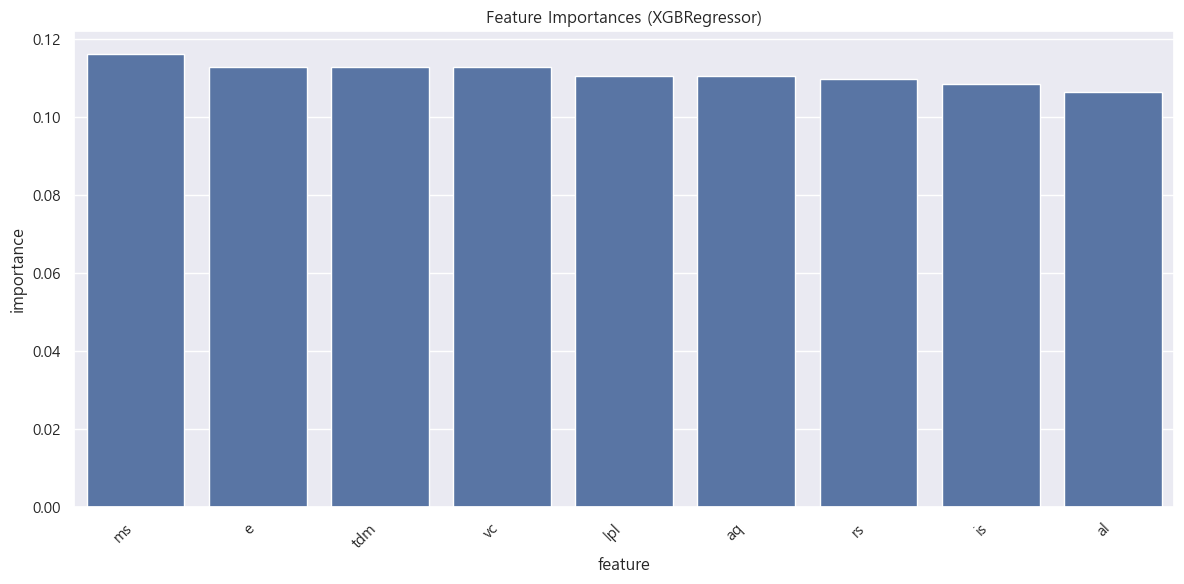

In [8]:
myscore(df = df, fi=True)

# 전처리 & 가공

## 이상치 처리

In [9]:
import pandas as pd
import numpy as np

###########################################################
# 1. IQR 기반 이상치 행 '삭제' (Trimming) - dft 사용
###########################################################

# 원본 DataFrame을 'dft'로 안전하게 복사
dft = df.copy()

# dft에서 숫자형 특성(feature)들의 리스트를 가져옴
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()

print(">> Trimming Process Start")
print("Original Shape (dft):", dft.shape)

# dft의 각 숫자형 특성에 대해 이상치 행 삭제
for col in num_features_for_trim:
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 정상 범위에 있는 행만 dft에 남김
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

# 최종 결과 확인
print("Trimmed Shape (dft):", dft.shape)
print("-" * 50)


###########################################################
# 2. IQR 기반 이상치 '대체' (Winsorization) - dfw 사용
###########################################################

# 원본 DataFrame을 'dfw'로 안전하게 복사
dfw = df.copy()

# dfw에서 숫자형 특성(feature)들의 리스트를 가져옴
num_features_for_winsorize = dfw.select_dtypes(include=np.number).columns.tolist()

print(">> Winsorization Process Start")
print("Original Shape (dfw):", dfw.shape)

# dfw의 각 숫자형 특성에 대해 이상치를 경계값으로 대체
for col in num_features_for_winsorize:
    Q1 = dfw[col].quantile(0.25)
    Q3 = dfw[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # dfw의 값을 np.where를 사용하여 대체
    dfw[col] = np.where(dfw[col] < lower_bound, lower_bound,
                        np.where(dfw[col] > upper_bound, upper_bound, dfw[col]))

# 최종 결과 확인
print("Winsorized Shape (dfw):", dfw.shape)
print("-" * 50)

>> Trimming Process Start
Original Shape (dft): (524164, 10)
Trimmed Shape (dft): (505206, 10)
--------------------------------------------------
>> Winsorization Process Start
Original Shape (dfw): (524164, 10)
Winsorized Shape (dfw): (524164, 10)
--------------------------------------------------


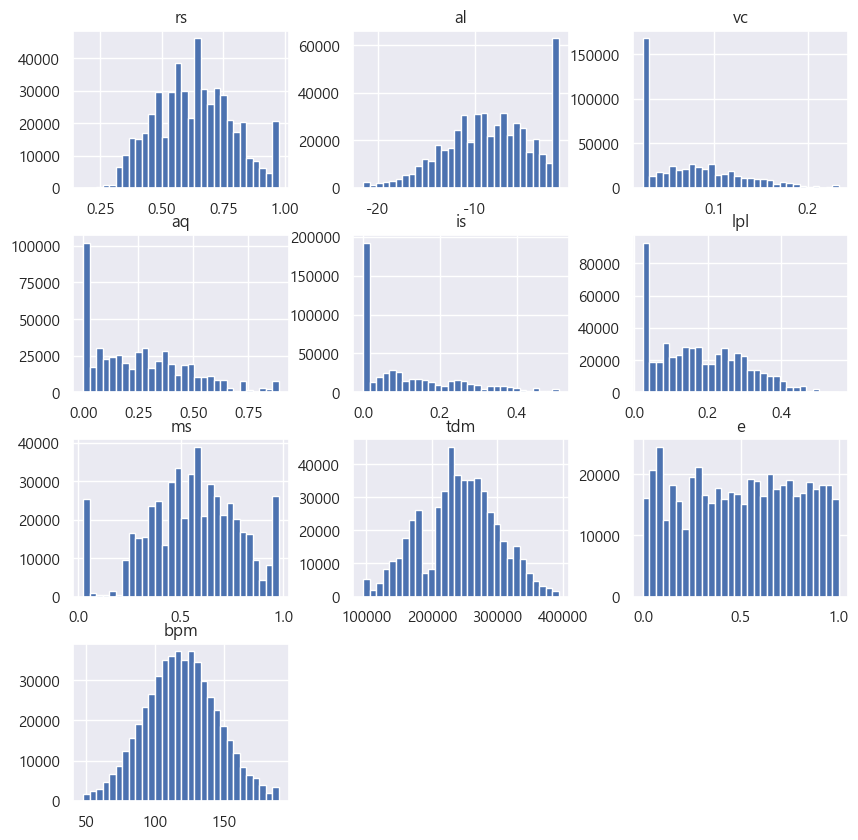

In [10]:
dfw.hist(figsize=(10, 10), bins=30)
plt.show()

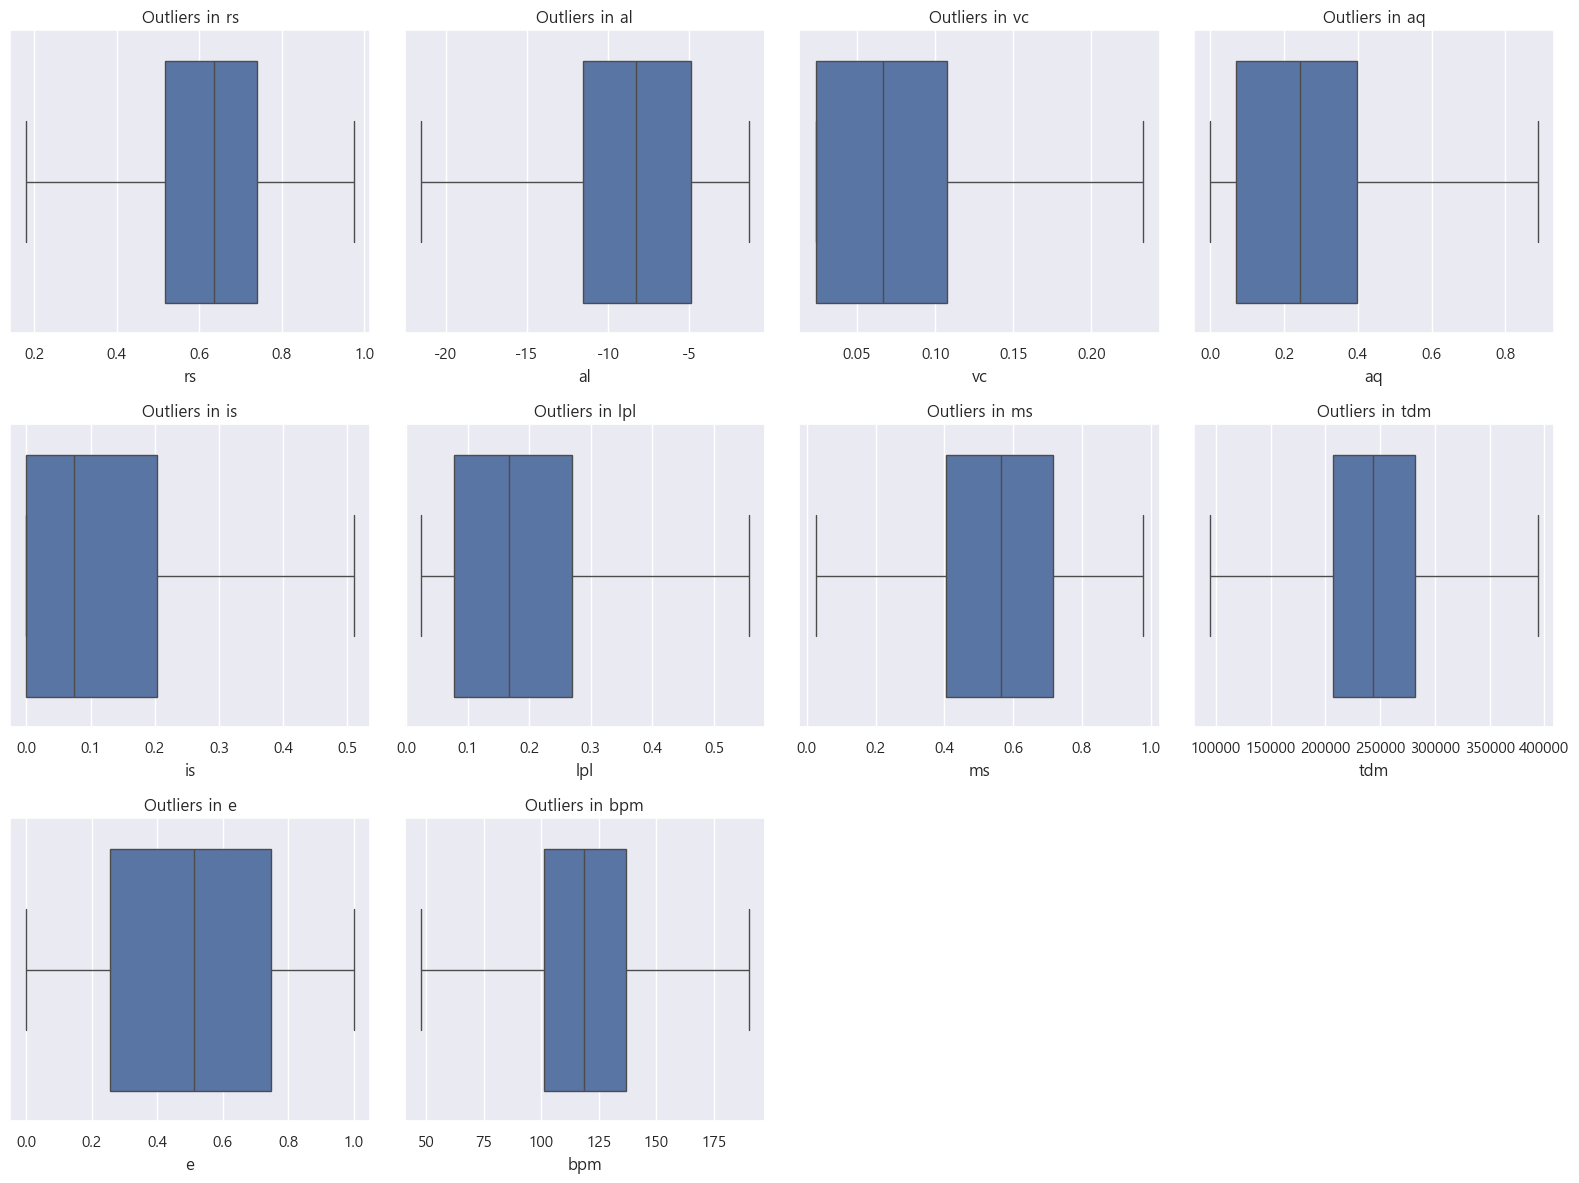

In [11]:
num_features = dfw.select_dtypes(include=np.number).columns.tolist()

# 1. 전체 그림의 크기와 격자(grid) 설정
n_features = len(num_features)
n_cols = 4  # 한 줄에 그릴 그래프의 개수 (원하는 대로 조절)
n_rows = math.ceil(n_features / n_cols) # 필요한 줄의 개수 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 다루기 쉽게 함

# 2. for문을 사용하여 각 subplot에 boxplot 그리기
for i, col in enumerate(num_features):
    sns.boxplot(x=dfw[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 3. 남는 빈 subplot들은 보이지 않게 처리
for j in range(n_features, len(axes)):
    axes[j].axis('off')

# 4. 전체 그림을 보기 좋게 조정하고 출력
plt.tight_layout()
plt.show()

### 점수 확인

In [12]:
myscore(df = dfw)

MODEL : XGBRegressor
MSE : 700.2772
RMSE : 26.4628
R2 : -0.0079
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 700.2772 vs 703.1462 (Change: -2.8689) 📈
RMSE : 26.4628 vs 26.5169 (Change: -0.0542) 📈
R2   : -0.0079 vs -0.0068 (Change: -0.0010) 📉
------------------------------



## 파생 피쳐 추가

In [13]:
dfw['tdn'] = dfw['tdm'] / 60000
dfw['ear'] = dfw['e'] / (dfw['aq'] + 1e-5)
dfw['vib'] = dfw['vc'] / (dfw['is'] + 1e-5)
dfw['mr'] = dfw['ms'] * dfw['rs']
dfw['pi'] = dfw['lpl'] * dfw['al']
dfw['re'] = dfw['rs'] * dfw['e']
dfw['ma'] = dfw['ms'] * dfw['aq']

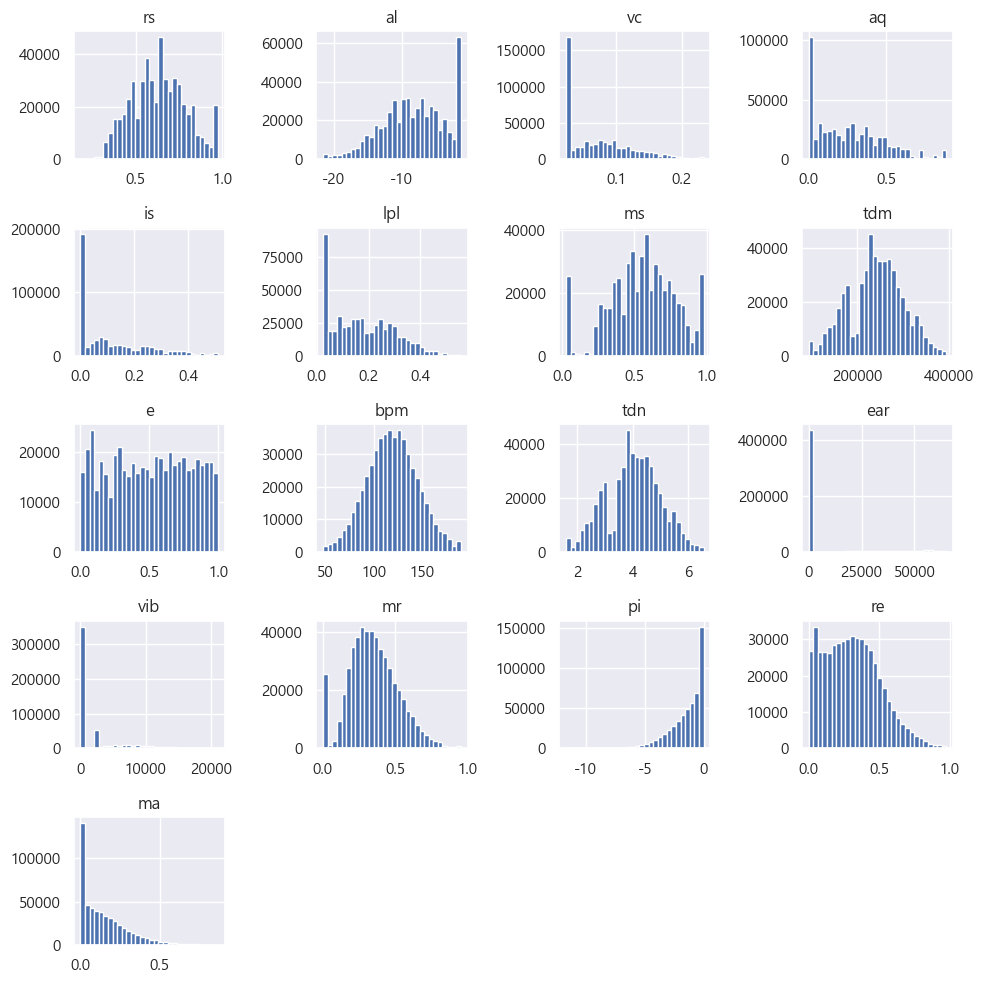

In [14]:
dfw.hist(figsize=(10, 10), bins=30)
plt.tight_layout()
plt.show()

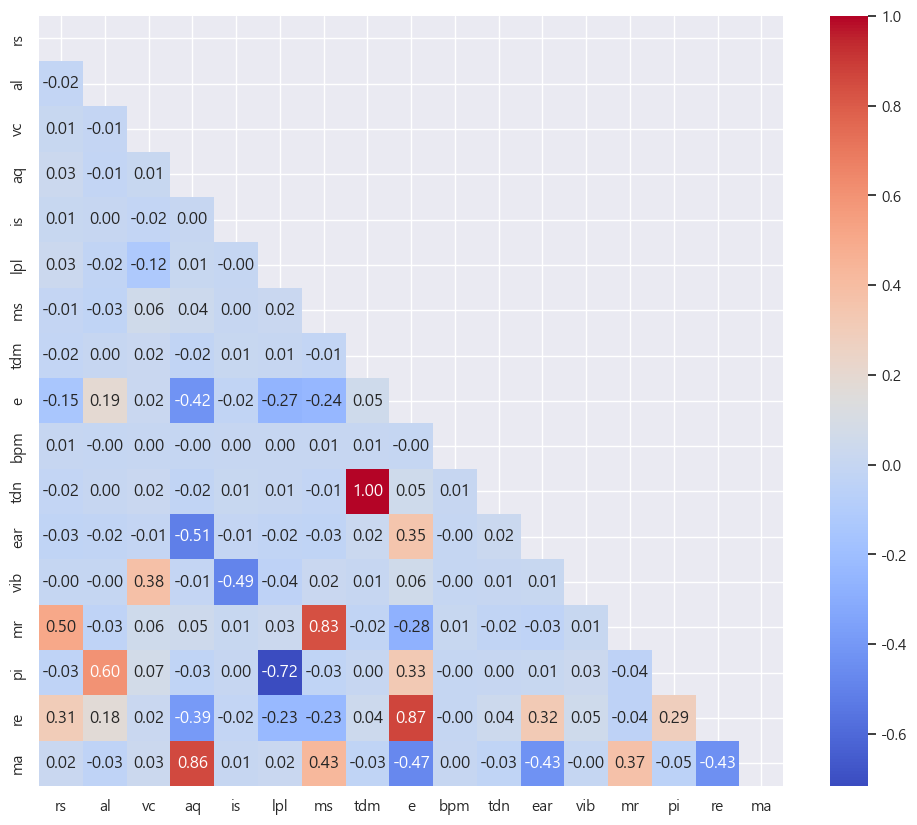

In [15]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(dfw.corr(), dtype=bool))
sns.heatmap(dfw.corr(), annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.show()

### 점수 확인

MODEL : XGBRegressor
MSE : 700.0797
RMSE : 26.4590
R2 : -0.0076
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 700.0797 vs 700.2772 (Change: -0.1975) 📈
RMSE : 26.4590 vs 26.4628 (Change: -0.0037) 📈
R2   : -0.0076 vs -0.0079 (Change: +0.0003) 📈
------------------------------



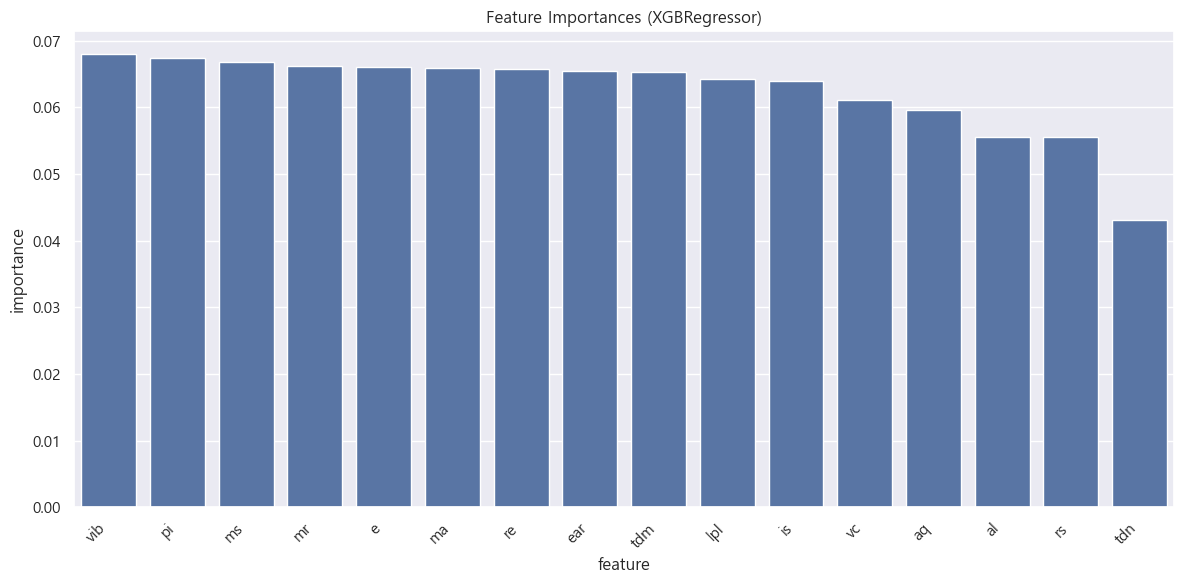

In [16]:
myscore(df = dfw, fi=True)

# 스케일 (& 점수 확인)

In [17]:
model_list = [XGBRegressor(),
              LGBMRegressor(verbosity=-1)]

scaler_list = [MinMaxScaler(), RobustScaler(), StandardScaler()]

y = dfw['bpm']
X = dfw.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

for sc in scaler_list:

    # 원칙상 chas(0 or 1)는 스케일링 안 함
    Xsc = sc.fit(X80)
    X80_scaler = Xsc.transform(X80)
    X20_scaler = Xsc.transform(X20)

    # 분류에서 타겟 y(0, 1, ...)는 스케일링 안 함
    # 그러나, 회귀에서는 타겟 y(연속형 수치)도 스케일링 해야 함
    ysc = sc.__class__()
    y80_scaler = ysc.fit_transform(y80.values.reshape(-1, 1))
    y20_scaler = ysc.fit_transform(y20.values.reshape(-1, 1))

    print(sc.__class__.__name__, '\n')
    for model in model_list:
        model.fit(X80_scaler, y80_scaler)
        pred_scaler = model.predict(X20_scaler)

        # 타겟 y와 예측값 pred는 스케일링된 값을 주기 때문에 점수내기 전에 원복시켜야 함
        y20_inv = ysc.inverse_transform(y20_scaler.reshape(-1, 1))
        pred_inv = ysc.inverse_transform(pred_scaler.reshape(-1, 1))
        
        mse = mean_squared_error(y20_inv, pred_inv)
        rmse = root_mean_squared_error(y20_inv, pred_inv)
        r2 = r2_score(y20_inv, pred_inv)
        print(f'MSE : {mse:.4f} RMSE : {rmse:.4f} R2 : {r2:.4f} MODEL : {model.__class__.__name__}')  
    print('--'*40, '\n')

MinMaxScaler 

MSE : 699.8316 RMSE : 26.4543 R2 : -0.0072 MODEL : XGBRegressor
MSE : 694.4922 RMSE : 26.3532 R2 : 0.0005 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 

RobustScaler 

MSE : 700.0150 RMSE : 26.4578 R2 : -0.0075 MODEL : XGBRegressor
MSE : 694.6325 RMSE : 26.3559 R2 : 0.0003 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 

StandardScaler 

MSE : 699.9008 RMSE : 26.4556 R2 : -0.0073 MODEL : XGBRegressor
MSE : 694.6939 RMSE : 26.3570 R2 : 0.0002 MODEL : LGBMRegressor
-------------------------------------------------------------------------------- 



# 중간 제출
* 이상치 & 파생피쳐 & 스케일

In [18]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 학습 데이터 로드
train_df = pd.read_csv('../data/train.csv')

# 테스트 데이터 로드 및 제출용 ID 저장
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']


# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 학습 데이터 전처리 ---
# id 제거 및 컬럼명 변경
train_df = train_df.drop('id', axis=1)
train_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']

# 이상치 처리 (Winsorization)
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound,
                           np.where(train_df[col] > upper_bound, upper_bound, train_df[col]))

# 파생 피쳐 추가
train_df['tdn'] = train_df['tdm'] / 60000
train_df['ear'] = train_df['e'] / (train_df['aq'] + 1e-5)
train_df['vib'] = train_df['vc'] / (train_df['is'] + 1e-5)
train_df['mr'] = train_df['ms'] * train_df['rs']
train_df['pi'] = train_df['lpl'] * train_df['al']
train_df['re'] = train_df['rs'] * train_df['e']
train_df['ma'] = train_df['ms'] * train_df['aq']


# --- 2-2. 테스트 데이터에도 동일한 전처리 과정을 적용합니다. ---
# id 제거 및 컬럼명 변경
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e'] # bpm 컬럼 없음

# 이상치 처리 (Winsorization)
# 중요: 테스트 데이터의 quantile이 아닌, 학습 데이터의 quantile을 사용해야 하나,
# 여기서는 편의상 각 데이터셋 기준으로 처리합니다.
numeric_features_test = test_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features_test:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    test_df[col] = np.where(test_df[col] < lower_bound, lower_bound,
                           np.where(test_df[col] > upper_bound, upper_bound, test_df[col]))

# 파생 피쳐 추가
test_df['tdn'] = test_df['tdm'] / 60000
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)
test_df['mr'] = test_df['ms'] * test_df['rs']
test_df['pi'] = test_df['lpl'] * test_df['al']
test_df['re'] = test_df['rs'] * test_df['e']
test_df['ma'] = test_df['ms'] * test_df['aq']


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# X와 y 데이터 준비
y_train = train_df['bpm']
X_train = train_df.drop('bpm', axis=1)
X_test = test_df.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서를 동일하게 맞춤
X_test = X_test[X_train.columns]

# 최종 모델 정의
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', MinMaxScaler()),
        ('my_model', LGBMRegressor(verbosity=-1, random_state=8989))
    ]),
    transformer=MinMaxScaler() # y값에 적용할 스케일러
)

# 전체 학습 데이터로 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 최종 예측 수행 (결과는 자동으로 역변환됨)
predictions = final_model.predict(X_test)
print("테스트 데이터에 대한 예측이 완료되었습니다.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.823408
1  524165  119.154888
2  524166  121.159489
3  524167  119.279225
4  524168  119.822438


# 파이프라인 (로그 + 스케일)

In [19]:
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

tran_pipe = TransformedTargetRegressor (
                Pipeline([ ('my_log1p', FunctionTransformer(np.log1p, validate=True)), 
                           ('my_scaler', StandardScaler()),
                           ('my_model', XGBRegressor())
                       ]),
                func=np.log1p, 
                inverse_func=np.expm1
)

## 점수 확인

In [20]:
myscore(df=dfw, model=tran_pipe)

MODEL : TransformedTargetRegressor
MSE : 709.5845
RMSE : 26.6380
R2 : -0.0213
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 709.5845 vs 700.0797 (Change: +9.5047) 📉
RMSE : 26.6380 vs 26.4590 (Change: +0.1790) 📉
R2   : -0.0213 vs -0.0076 (Change: -0.0137) 📉
------------------------------



## 중간 제출
* 이상치 & 파생피쳐 & 로그 + 스케일

In [281]:
# ==============================================================================
# 1. 데이터 로드 (학습 데이터와 테스트 데이터)
# ==============================================================================
# 실제 캐글 환경에 맞는 경로를 사용합니다.
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
# test_ids는 제출 파일 생성을 위해 미리 저장해 둡니다.
test_ids = test_df['id']


# ==============================================================================
# 2. 전처리 함수 정의 (기존과 동일)
# ==============================================================================
def preprocess_data(df):
    """데이터프레임에 전처리를 적용하는 함수"""
    
    # --- id 제거 및 컬럼명 변경 ---
    # bpm 컬럼이 있으면 학습 데이터, 없으면 테스트 데이터로 간주
    if 'BeatsPerMinute' in df.columns or 'bpm' in df.columns: # 원본 컬럼명도 체크
        df = df.drop('id', axis=1)
        # 학습 데이터에는 10개의 컬럼명 지정
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
    else:
        df = df.drop('id', axis=1)
        # 테스트 데이터에는 9개의 컬럼명 지정
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']

    # --- 이상치 처리 (Winsorization) ---
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    if 'bpm' in numeric_features:
        numeric_features.remove('bpm') # 타겟 변수는 이상치 처리에서 제외

    for col in numeric_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    # --- 파생 피쳐 추가 ---
    df['tdn'] = df['tdm'] / 60000
    df['ear'] = df['e'] / (df['aq'] + 1e-5)
    df['vib'] = df['vc'] / (df['is'] + 1e-5)
    df['mr'] = df['ms'] / (df['rs'] + 1e-5) # 상관관계가 높아 나눗셈으로 변경 시도
    df['pi'] = df['lpl'] * df['al']
    df['re'] = df['rs'] * df['e']
    df['ma'] = df['ms'] * df['aq']
    
    return df

# ==============================================================================
# 3. 데이터 전처리 적용
# ==============================================================================
train_processed_df = preprocess_data(train_df.copy())
test_processed_df = preprocess_data(test_df.copy())


# ==============================================================================
# 4. 최종 모델 정의 및 전체 데이터로 학습
# ==============================================================================
# X와 y 데이터 준비
y_train = train_processed_df['bpm']
X_train = train_processed_df.drop(columns=['bpm'])

# [수정된 부분] 요청하신 새로운 파이프라인 모델로 변경
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_log1p', FunctionTransformer(np.log1p, validate=False)), # 로그 변환
        ('my_scaler', StandardScaler()),                             # StandardScaler 사용
        ('my_model', XGBRegressor(random_state=8989))                # XGBRegressor 사용
    ]),
    func=np.log1p,      # y값에 적용할 함수
    inverse_func=np.expm1 # 예측값에 적용할 역함수
)

# 전체 학습 데이터로 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")


# ==============================================================================
# 5. 제출용 데이터 예측
# ==============================================================================
# 학습에 사용된 피쳐 순서를 그대로 테스트 데이터에 적용
train_features = X_train.columns
X_test_final = test_processed_df[train_features]

# 최종 예측 수행 (결과는 자동으로 역변환됨)
predictions = final_model.predict(X_test_final)


# ==============================================================================
# 6. 제출 파일 생성
# ==============================================================================
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  115.947258
1  524165  114.794853
2  524166  117.064171
3  524167  118.302979
4  524168  119.895798


# 특정 피쳐만 파이프라인

In [21]:
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

# 로그 변환 대상
log_features = ['vc', 'aq', 'is']

# 1️⃣ 피처 변환 파이프라인
feature_pipe = ColumnTransformer([
    ('log_transform', FunctionTransformer(np.log1p, validate=True), log_features),
    ('pass', 'passthrough', [col for col in X80.columns if col not in log_features])
])

# 2️⃣ 전체 모델 파이프라인
model = Pipeline([
    ('feature_pipe', feature_pipe),
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor())
])

# 3️⃣ 타깃 로그변환 + 역변환 자동 적용
tran_pipe2 = TransformedTargetRegressor(
    regressor=model,
    func=np.log1p,
    inverse_func=np.expm1
)

## 점수 확인

In [22]:
myscore(df=dfw, model=tran_pipe2)

MODEL : TransformedTargetRegressor
MSE : 710.0108
RMSE : 26.6460
R2 : -0.0219
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 710.0108 vs 709.5845 (Change: +0.4263) 📉
RMSE : 26.6460 vs 26.6380 (Change: +0.0080) 📉
R2   : -0.0219 vs -0.0213 (Change: -0.0006) 📉
------------------------------



# 스태킹

In [23]:
# # ====================================
# # 2️⃣ Base models (XGB + LGBM)
# # ====================================
# xgb = XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     tree_method='gpu_hist',  # ✅ GPU 학습
#     predictor='gpu_predictor'
# )

# lgbm = LGBMRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     num_leaves=31,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1,
#     device='gpu'
# )

# # ====================================
# # 3️⃣ Meta model (stacking layer)
# # ====================================
# # 보통 간단한 Ridge나 LinearRegression 사용
# meta_model = RidgeCV(alphas=np.logspace(-3, 3, 7))
# #후보 alpha: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# # ====================================
# # 4️⃣ Stacking Regressor
# # ====================================
# stack_model = StackingRegressor(
#     estimators=[
#         ("xgb", xgb),
#         ("lgbm", lgbm)
#     ],
#     final_estimator=meta_model,
#     passthrough=False,  # base 모델 입력을 meta model에 추가할지 여부
#     n_jobs=-1
# )

# # ====================================
# # 6️⃣ 학습 및 평가
# # ====================================
# stack_model.fit(X80, y80)
# pred = stack_model.predict(X20)

# mse = mean_squared_error(y20, pred)
# print("Stacking MSE:", mse)

## 점수 확인

In [24]:
# myscore(df=dfw)

# 규제 (& 점수 확인)

In [286]:
alphas = [0.01, 0.1, 1, 10, 100]

print("===== ElasticNet Hyperparameter Tuning with myscore =====")

for alpha_value in alphas:
    print(f"\nTesting alpha = {alpha_value}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(alpha=alpha_value, random_state=8989))
    ])
    
    myscore(X80=X80, y80=y80, X20=X20, y20=y20, model=pipeline)

===== ElasticNet Hyperparameter Tuning with myscore =====

Testing alpha = 0.01
MODEL : Pipeline
MSE : 694.6674
RMSE : 26.3565
R2 : 0.0002
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 694.6674 vs 710.0108 (Change: -15.3434) 📈
RMSE : 26.3565 vs 26.6460 (Change: -0.2895) 📈
R2   : 0.0002 vs -0.0219 (Change: +0.0221) 📈
------------------------------


Testing alpha = 0.1
MODEL : Pipeline
MSE : 694.7012
RMSE : 26.3572
R2 : 0.0002
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 694.7012 vs 694.6674 (Change: +0.0338) 📉
RMSE : 26.3572 vs 26.3565 (Change: +0.0006) 📉
R2   : 0.0002 vs 0.0002 (Change: -0.0000) 📉
------------------------------


Testing alpha = 1
MODEL : Pipeline
MSE : 694.8150
RMSE : 26.3593
R2 : -0.0000
------------------------------
--- Score Comparison (Current vs Previous) ---
MSE  : 694.8150 vs 694.7012 (Change: +0.1138) 📉
RMSE : 26.3593 vs 26.3572 (Change: +0.0022) 📉
R2   : -0.0000 vs 0.0002 (Change

## 중간 제출
* 이상치 & 파생피쳐 & 스케일 & 규제

In [289]:
# ==============================================================================
# 1. 데이터 준비 (학습 데이터와 테스트 데이터 로드)
# ==============================================================================
# 학습 데이터 로드
train_df = pd.read_csv('../data/train.csv')

# 테스트 데이터 로드 및 제출용 ID 저장
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']


# ==============================================================================
# 2. 전처리 (학습 데이터와 테스트 데이터에 동일하게 적용)
# ==============================================================================

# --- 2-1. 학습 데이터 전처리 ---
# id 제거 및 컬럼명 변경
train_df = train_df.drop('id', axis=1)
train_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']

# 이상치 처리 (Winsorization)
numeric_features = train_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[col] = np.where(train_df[col] < lower_bound, lower_bound,
                           np.where(train_df[col] > upper_bound, upper_bound, train_df[col]))

# 파생 피쳐 추가
train_df['tdn'] = train_df['tdm'] / 60000
train_df['ear'] = train_df['e'] / (train_df['aq'] + 1e-5)
train_df['vib'] = train_df['vc'] / (train_df['is'] + 1e-5)
train_df['mr'] = train_df['ms'] * train_df['rs']
train_df['pi'] = train_df['lpl'] * train_df['al']
train_df['re'] = train_df['rs'] * train_df['e']
train_df['ma'] = train_df['ms'] * train_df['aq']


# --- 2-2. 테스트 데이터에도 동일한 전처리 과정을 적용합니다. ---
# id 제거 및 컬럼명 변경
test_df = test_df.drop('id', axis=1)
test_df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e'] # bpm 컬럼 없음

# 이상치 처리 (Winsorization)
numeric_features_test = test_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_features_test:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    test_df[col] = np.where(test_df[col] < lower_bound, lower_bound,
                           np.where(test_df[col] > upper_bound, upper_bound, test_df[col]))

# 파생 피쳐 추가
test_df['tdn'] = test_df['tdm'] / 60000
test_df['ear'] = test_df['e'] / (test_df['aq'] + 1e-5)
test_df['vib'] = test_df['vc'] / (test_df['is'] + 1e-5)
test_df['mr'] = test_df['ms'] * test_df['rs']
test_df['pi'] = test_df['lpl'] * test_df['al']
test_df['re'] = test_df['rs'] * test_df['e']
test_df['ma'] = test_df['ms'] * test_df['aq']


# ==============================================================================
# 3. 모델 학습 (전체 학습 데이터 사용)
# ==============================================================================
# X와 y 데이터 준비
y_train = train_df['bpm']
X_train = train_df.drop('bpm', axis=1)
X_test = test_df.copy()

# 학습 데이터와 테스트 데이터의 컬럼 순서를 동일하게 맞춤
X_test = X_test[X_train.columns]

# --- [수정된 부분] 최종 모델을 ElasticNet 파이프라인으로 변경 ---
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', StandardScaler()),  # 선형 모델이므로 StandardScaler 사용
        ('my_model', ElasticNet(alpha=0.01, random_state=8989)) # alpha=0.01로 설정
    ]),
    transformer=StandardScaler() # y값에 적용할 스케일러도 일관성 있게 변경
)

# 전체 학습 데이터로 모델 훈련
final_model.fit(X_train, y_train)
print("최종 모델 학습이 완료되었습니다.")


# ==============================================================================
# 4. 예측 (테스트 데이터 사용)
# ==============================================================================
# 최종 예측 수행 (결과는 자동으로 역변환됨)
predictions = final_model.predict(X_test)
print("테스트 데이터에 대한 예측이 완료되었습니다.")


# ==============================================================================
# 5. 제출 파일 생성
# ==============================================================================
submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.008733
1  524165  119.018850
2  524166  119.010672
3  524167  119.093184
4  524168  119.060006


# 피쳐 셀렉션

In [292]:
# 1. 데이터 준비 (dfw가 이미 전처리되었다고 가정)
y = dfw['bpm']
X = dfw.drop('bpm', axis=1)

# 2. Ridge 모델을 estimator로 사용하여 SelectFromModel 객체 생성
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0), 
    threshold='median' # 계수(중요도)의 중앙값보다 큰 피쳐만 선택
)

# 3. 원본 데이터 X로 selector를 바로 학습
selector.fit(X, y)

# 4. 선택된 피쳐 확인
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

print(f"총 {len(X.columns)}개의 피쳐 중 {len(selected_features)}개가 선택되었습니다.")
print("\n[선택된 피쳐 목록]")
print(list(selected_features))

# 5. 원본 데이터를 선택된 피쳐만 남도록 변환
X_selected = selector.transform(X)

print(f"\n원본 데이터 형태: {X.shape}")
print(f"피쳐 선택 후 데이터 형태: {X_selected.shape}")

총 16개의 피쳐 중 8개가 선택되었습니다.

[선택된 피쳐 목록]
['rs', 'vc', 'aq', 'lpl', 'ms', 'e', 'mr', 're']

원본 데이터 형태: (524164, 16)
피쳐 선택 후 데이터 형태: (524164, 8)


## 중간 제출
* 이상치 & 파생피쳐 & 스케일 & 규제 & 피쳐셀렉션

In [293]:
# ==============================================================================
# 1. 데이터 로드
# ==============================================================================
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

# ==============================================================================
# 2. 전처리 함수 정의 (재사용을 위해)
# ==============================================================================
def preprocess_data(df, is_train=True):
    """데이터프레임에 공통 전처리 과정을 적용하는 함수"""
    
    # id 제거 및 컬럼명 변경
    df = df.drop('id', axis=1)
    if is_train:
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
    else:
        df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e']
    
    # 이상치 처리 (Winsorization)
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    if 'bpm' in numeric_features:
        numeric_features.remove('bpm')

    for col in numeric_features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                           np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    # 파생 피쳐 추가
    df['tdn'] = df['tdm'] / 60000
    df['ear'] = df['e'] / (df['aq'] + 1e-5)
    df['vib'] = df['vc'] / (df['is'] + 1e-5)
    df['mr'] = df['ms'] * df['rs']
    df['pi'] = df['lpl'] * df['al']
    df['re'] = df['rs'] * df['e']
    df['ma'] = df['ms'] * df['aq']
    
    return df

# ==============================================================================
# 3. 데이터 전처리 적용
# ==============================================================================
train_processed_df = preprocess_data(train_df.copy(), is_train=True)
test_processed_df = preprocess_data(test_df.copy(), is_train=False)

# ==============================================================================
# 4. 피쳐 선택 (Feature Selection)
# ==============================================================================
# 학습 데이터에서 X와 y 분리
y_train_full = train_processed_df['bpm']
X_train_full = train_processed_df.drop('bpm', axis=1)

# Ridge 모델 기반의 SelectFromModel 생성
# (주의: 스케일링 없이 진행하므로 값의 범위가 큰 피쳐가 선택에 유리할 수 있습니다.)
selector = SelectFromModel(
    estimator=Ridge(alpha=1.0), 
    threshold='median'
)

# 전체 학습 데이터로 피쳐 선택기 학습
selector.fit(X_train_full, y_train_full)

# 선택된 피쳐의 이름들을 가져옴
selected_features = X_train_full.columns[selector.get_support()]
print(f"총 {len(X_train_full.columns)}개의 피쳐 중 {len(selected_features)}개가 선택되었습니다.")
print("선택된 피쳐:", list(selected_features))

# ==============================================================================
# 5. 선택된 피쳐만 사용하여 데이터 준비
# ==============================================================================
X_train_selected = X_train_full[selected_features]
X_test_selected = test_processed_df[selected_features]

# ==============================================================================
# 6. 최종 모델 정의 및 학습
# ==============================================================================
final_model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('my_scaler', MinMaxScaler()),
        ('my_model', LGBMRegressor(verbosity=-1, random_state=8989))
    ]),
    transformer=MinMaxScaler()
)

# 선택된 피쳐만으로 최종 모델 훈련
final_model.fit(X_train_selected, y_train_full)
print("\n최종 모델 학습이 완료되었습니다.")

# ==============================================================================
# 7. 예측 및 제출 파일 생성
# ==============================================================================
predictions = final_model.predict(X_test_selected)
print("테스트 데이터에 대한 예측이 완료되었습니다.")

submission = pd.DataFrame({
    "id": test_ids,
    "bpm": predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성이 완료되었습니다.")
print(submission.head())

총 16개의 피쳐 중 8개가 선택되었습니다.
선택된 피쳐: ['rs', 'vc', 'aq', 'lpl', 'ms', 'e', 'mr', 're']

최종 모델 학습이 완료되었습니다.
테스트 데이터에 대한 예측이 완료되었습니다.
submission.csv 파일 생성이 완료되었습니다.
       id         bpm
0  524164  119.062453
1  524165  118.892675
2  524166  118.809767
3  524167  119.163531
4  524168  119.195157


# 튜닝

In [297]:
# # 1. 데이터 준비 (이전에 전처리된 dfw 데이터프레임을 사용한다고 가정)
# # PyCaret은 원본 데이터프레임을 직접 사용합니다.
# data = dfw.copy()

# # 2. PyCaret 환경 설정
# # 'data'에는 데이터프레임을, 'target'에는 예측할 컬럼명을 지정합니다.
# # session_id는 재현성을 위한 random_state와 같습니다.
# print("Setting up PyCaret environment...")
# s = setup(data=data, target='bpm', session_id=8989)

# # 3. LightGBM 모델 생성
# # 'lightgbm'이라는 약어를 사용해 모델을 만듭니다.
# # 이 단계에서는 기본 파라미터로 교차 검증 점수를 확인합니다.
# print("\nCreating LightGBM model...")
# lightgbm = create_model('lightgbm')

# # 4. 모델 튜닝
# # create_model()로 만든 모델을 tune_model()에 넣어 튜닝을 시작합니다.
# # PyCaret이 자동으로 최적의 하이퍼파라미터를 찾습니다.
# print("\nTuning LightGBM model...")
# tuned_lightgbm = tune_model(lightgbm)

# # 5. 최종 모델 확정
# # 튜닝된 최적의 파라미터로 전체 학습 데이터에 대해 다시 학습합니다.
# print("\nFinalizing the tuned model...")
# final_model = finalize_model(tuned_lightgbm)

# # 6. 최종 모델 확인
# # 확정된 모델의 파라미터를 확인할 수 있습니다.
# print("\nFinal Tuned Model:")
# print(final_model)